In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [4]:
name = f"pix2pix_bs16_ep1_lambda1000_vanilla"
output_dir = f"../output/{name}"

input_id = ["z1.3_ha", "z2.0_oiii"]
output_id = ["z1.3_ha"]

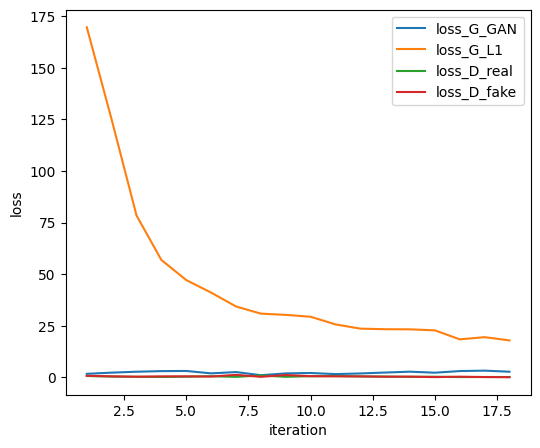

In [5]:
# loss function
fname = f"{output_dir}/loss_log.txt"

df = pd.read_csv(fname, sep=" ", header=0)
header = df.columns

plt.figure(figsize=(6,5))
plt.xlabel("iteration")
plt.ylabel("loss")

epoch = df["#iter"]
key_list = header[4:]
for i, key in enumerate(key_list):
    plt.plot(epoch, df[key], label=key)
plt.legend(loc="upper right")

plt.savefig("loss.png")

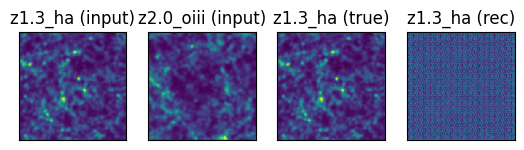

In [7]:
def my_imshow(data, ax, title=None, vmin=None, vmax=None):
    ax.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
    ax.set_title(title)
    im = ax.imshow(data, interpolation="none", vmin=vmin, vmax=vmax)   
    return im

data_name = f"run0_index0"

fig, axs = plt.subplots(1, len(input_id)+len(output_id)*2)
axs = axs.flatten()
count = 0

# input data
for id in input_id:
    f = f"../test_data/{data_name}_{id}.fits"
    data = fits.open(f)[0].data
    my_imshow(data, axs[count], title=id + " (input)")
    count += 1

# output data (true)
for id in output_id:
    f = f"../test_data/{data_name}_{id}.fits"
    data = fits.open(f)[0].data
    my_imshow(data, axs[count], title=id + " (true)")
    count += 1

# output data (reconstructed)
for i, id in enumerate(output_id):
    f = f"{output_dir}/test/gen_{data_name}_{i}.fits"
    data = fits.open(f)[0].data
    my_imshow(data, axs[count], title=id + " (rec)")
    count += 1
    
plt.savefig("test_image.png")

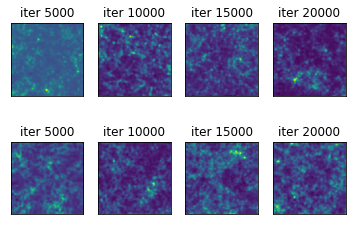

In [10]:
# reproduced maps during training
freq = 5000

nmap = 4
iter_list = [ (i+1) * freq for i in range(nmap) ]
nmap = len(iter_list)

fig, axs = plt.subplots(2, nmap)
for i, iter in enumerate(iter_list):
    for j, id in enumerate(["_0", "_1"]):
        fname = "{}/iter_{:d}{}.fits".format(output_dir, iter, id)
        data = fits.open( fname )[0].data

        ax = axs[j,i]
        ax.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
        ax.set_title("iter {:d}".format(iter))
        im = ax.imshow(data, interpolation="none")    

plt.savefig("training_iter.png")

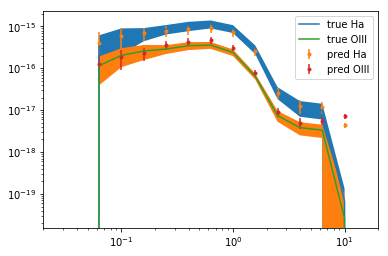

In [11]:
# power spectra
plt.xscale("log")
plt.yscale("log")
plt.xlim([0.02, 20])
labels = [ "Ha", "OIII" ]
snames = [ "z1.3_ha", "z2.0_oiii" ]
for i, sname in enumerate(snames):
    fname = f"../calculation/output/ps_{sname}_{name}.txt"
    data = np.loadtxt(fname)
    k = data[:,0]
    true = data[:,1]
    s_true = data[:,2]
    pred = data[:,3]
    s_pred = data[:,4]
    
    plt.plot(k, true, label=f"true {labels[i]}")
    plt.fill_between(k, true+s_true, true-s_true)
    plt.errorbar(k, pred, s_pred, fmt=".", label=f"pred {labels[i]}")
    
plt.legend()

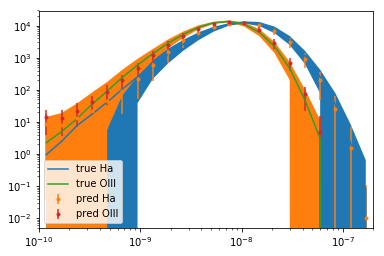

In [20]:
# probability distribution function

plt.xscale("log")
plt.yscale("log")
plt.xlim([1e-10,2e-7])

labels = [ "Ha", "OIII" ]
snames = [ "z1.3_ha", "z2.0_oiii" ]

for i, sname in enumerate(snames):
    fname = f"../calculation/output/pdf_log_{sname}_{name}.txt"
    data = np.loadtxt(fname)
    x = data[:,0]
    true = data[:,1]
    s_true = data[:,2]
    pred = data[:,3]
    s_pred = data[:,4]
    
    plt.plot(x, true, label=f"true {labels[i]}")
    plt.fill_between(x, true+s_true, true-s_true)
    plt.errorbar(x, pred, s_pred, fmt=".", label=f"pred {labels[i]}")
    
plt.legend()

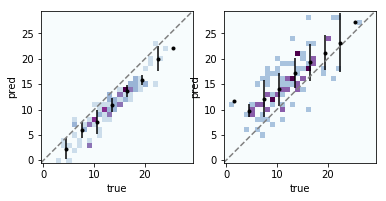

In [21]:
# mean prediction
xmins = [ 0.75, 0.55 ]
xmaxs = [ 1.75, 1.05 ]
fig, axs = plt.subplots(1,2)
for i, sname in enumerate(snames):
    ax = axs[i]

    fname = f"../calculation/output/mean_mesh_{sname}_{name}.txt"
    data = np.loadtxt(fname)
    ax.imshow(data, cmap="BuPu", origin="lower")
    nmesh = len(data)
    
    fname = f"../calculation/output/mean_{sname}_{name}.txt"
    data = np.loadtxt(fname) 
    coef = nmesh / ( xmaxs[i] - xmins[i] )
    x = ( data[:,0] - xmins[i] ) * coef
    y = ( data[:,1] - xmins[i] ) * coef
    e = data[:,2] * coef
    ax.errorbar(x, y, e, fmt=".", color="k")
    
    ax.set_xlim([-0.5,nmesh-0.5])
    ax.set_ylim([-0.5,nmesh-0.5])
    
    ax.set_xlabel("true")
    ax.set_ylabel("pred")
    
    xlim = ax.get_xlim()
    xx = np.linspace(xlim[0],xlim[1],10)
    ax.plot(xx, xx, color="gray", ls="--")